<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# ARIMA Lab    


*Authors:*  
 - Joseph Nelson (DC)        
 - Boom Devahastin Na Ayudhya (NYC)     
 - Bethany Poulin (Boston) 

---

## Introduction


The most common application for AR, ARMA, and ARIMA models is inventory planning. Planning inventory for a small shop can be difficult enough, but you've just been hired to plan inventory for a _big_ store - Walmart.

In this lab, you will be analyzing weekly Walmart sales data over a two year period from 2010 to 2012. The data is separated by store and by department, but you should focus on analyzing one store for simplicity. Your supervisor has set out the following goals for this project:

1. Record any observed trends in the data.
2. Produce a trained model to predict future sales numbers.
3. Include useful AND COMMENT ON how graphs (ACF, PACF) impact your modelling decisions throughout your notebook.

Try your best to tune your model. It can be difficult, but don't worry - time series analysis is a difficult and specialized topic.

## Exercise
---

#### Requirements

- Assemble observations and graphs as well as timeseries models in a notebook.


#### Additional Resources

1. [ARMA Example](https://www.statsmodels.org/dev/examples/notebooks/generated/tsa_arma_0.html)
2. [ARMA Models for TSA](https://www.quantstart.com/articles/Autoregressive-Moving-Average-ARMA-p-q-Models-for-Time-Series-Analysis-Part-1)

#### Things to Consider

You should always be looking for ways to reduce redundancy in your code, improve consistency in your output, and make it easier for others to follow your work! Functions are a huge part of this endeavor!

While working on this lab, you may try a number of $p$, $q$, and $d$ values to best account for your data. Because you will likely be repeating yourself, it is useful to create functions that declutter your workspace.

 - You may want to create a wrapper around the Augmented Dickey-Fuller test to provide both results and context for the output.
 - You may find value in a combined ACF & PACF function.
 - You may find it cleaner to build a function to make residual graphs and print out MSE all at once.

### Importing Necessary Libraries & Loading Data

In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split

%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")

data = pd.read_csv('./datasets/train.csv')
data.set_index('Date', inplace=True)
data.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


## Exploratory Analysis

#### 0. Preprocessing Data
It's always a good idea to evaluate the current state of your data. For every set of data this means something different. But the bare minimum is understanding what types of data you have, knowing if there are missing values and checking to be sure that your date column (or index) is in a proper date format.

Accordingly you should check:
 - Format of date column/index
 - Data types for each column
 - Whether or not we will have to deal with missing data

In [207]:
# 'Date' not in proper format
data.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


In [208]:
data = data.sort_index()

In [209]:
data.set_index(pd.DatetimeIndex(data.index), inplace=True)

In [210]:
# Shape of date
data.shape

(421570, 4)

In [211]:
# Proper data types
data.dtypes

Store             int64
Dept              int64
Weekly_Sales    float64
IsHoliday          bool
dtype: object

In [212]:
# No missing data
data.isna().sum()

Store           0
Dept            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [213]:
# Number of unique stores in dataframe
data['Store'].nunique()

45

#### 1. Extracting Data to Model

Our data set has a number of stores, each with weekly sales volumes for many departments. 

To facilitate our first time series model, we need to use a single store, and aggregate the total sales for all departments.

**Aggregate all of the sales for STORE 1 into a new dataframe called `Weekly_Sales`.**


In [214]:
data[data['Store'] == 1].index.nunique()

143

In [215]:
data.resample('W', closed='left').sum()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-07,65124,130557,49750740.50,0.0
2010-02-14,65082,131179,48336677.63,2956.0
2010-02-21,65610,131897,48276993.78,0.0
2010-02-28,65045,130161,43968571.13,0.0
2010-03-07,64897,129670,46871470.30,0.0
...,...,...,...,...
2012-09-30,65866,130785,43734899.40,0.0
2012-10-07,66296,132468,47566639.31,0.0
2012-10-14,66453,133371,46128514.25,0.0


In [216]:
def agg(df, column, name_column_total, store_number):
    total = []
    mask = df[df['Store'] == store_number]
    Weekly_Sales = mask[[name_column_total]].resample('W', closed='left').sum()
    Weekly_Sales['store'] = store_number

    return Weekly_Sales

In [217]:
Weekly_Sales = agg(data, 'Dept', 'Weekly_Sales', 1)

#### 2. Plotting & Interpreting Time Series

Plots are a central part of all time series analysis. You should always start with a basic line plot.

**2a. Generate a line plot for `Weekly_Sales` with time on the $x$-axis.**

In [218]:
# Code modified from code written by Matthew Garton.

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=18);

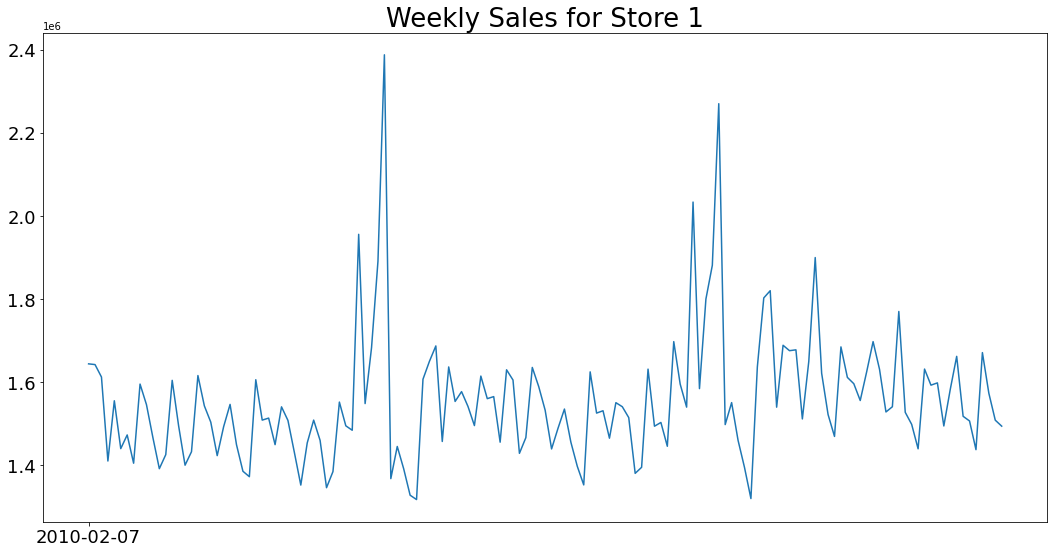

In [219]:
# Generate a time plot of our data.
plot_series(Weekly_Sales,
            ['Weekly_Sales'],
            title = 'Weekly Sales for Store 1',
            steps = 143)

Smoothing can help us see trends in the data. With time series, this frequently means plotting a rolling mean.

You might start looking at a one week roll, but you consider several 'windows' of time. 
 - What would a four week rolling mean look like? 
 - How about quarterly? 
 - Or annually? 

**2b. Calculate the rolling mean(s) for `Weekly_Sales` then plot them on a single set of axes.**

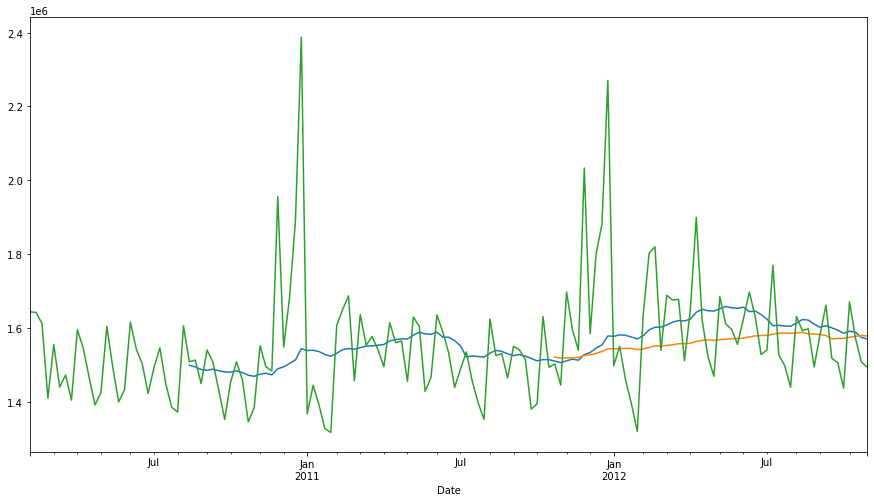

In [220]:
plt.figure(figsize=(15,8))
Weekly_Sales['Weekly_Sales'].rolling(28).mean().plot();
Weekly_Sales['Weekly_Sales'].rolling(90).mean().plot();
Weekly_Sales['Weekly_Sales'].rolling(1).mean().plot();

**2c. What can you say about patterns in the data based on the rolling mean plot above?**

*Answer:* We can see in the rolling mean for 365 days there seems to be seasonality in our data. During the holiday season there is a spike in weekly sales.

#### 3. Autocorrelations

We've learned about autocorrelation: the influence a serial observation has on the observations which follow.

Calculate autocorrelation in your `Weekly_Sales` data so that you can answer the question: 'How does autocorrelation differ as lag-weeks vary?'

**3a. Check at least three lag intervals (but feel free to explore others):**
 - **1 week**
 - **2 weeks**
 - **1 year (52 weeks)**

In [221]:
Weekly_Sales['Weekly_Sales_lag_1'] = Weekly_Sales['Weekly_Sales'].shift(1)
Weekly_Sales['Weekly_Sales_lag_2'] = Weekly_Sales['Weekly_Sales'].shift(2)
Weekly_Sales['Weekly_Sales_lag_3'] = Weekly_Sales['Weekly_Sales'].shift(3)

In [222]:
Weekly_Sales.head()

,Weekly_Sales,store,Weekly_Sales_lag_1,Weekly_Sales_lag_2,Weekly_Sales_lag_3
Date,,,,,
2010-02-07,1643690.90,1,NaN,NaN,NaN
2010-02-14,1641957.44,1,1643690.90,NaN,NaN
2010-02-21,1611968.17,1,1641957.44,1643690.90,NaN
2010-02-28,1409727.59,1,1611968.17,1641957.44,1643690.90
2010-03-07,1554806.68,1,1409727.59,1611968.17,1641957.44


In [223]:
Weekly_Sales.tail()

,Weekly_Sales,store,Weekly_Sales_lag_1,Weekly_Sales_lag_2,Weekly_Sales_lag_3
Date,,,,,
2012-09-30,1437059.26,1,1506126.06,1517428.87,1661767.33
2012-10-07,1670785.97,1,1437059.26,1506126.06,1517428.87
2012-10-14,1573072.81,1,1670785.97,1437059.26,1506126.06
2012-10-21,1508068.77,1,1573072.81,1670785.97,1437059.26
2012-10-28,1493659.74,1,1508068.77,1573072.81,1670785.97


**3b. What can you say about the series based on these autocorrelations?**

**Answer:** A trend might exist since we have high auto correlations for the first and last point. From these plot there is not much evidence of seasonality.

**3c. Plotting ACF and PCF**
As we learned in lecture, plotting the `Autocorrelation Function` and `Partial Autocorrelation Functions` can be useful in understanding seasonality in time series data.

Make a 52-week `ACF` and 52-week `PACF` plot now.

In [224]:
from statsmodels.graphics.tsaplots import plot_acf

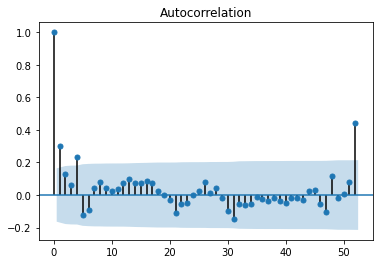

In [225]:
# ACF
plot_acf(Weekly_Sales['Weekly_Sales'], lags = 52);

In [226]:
from statsmodels.graphics.tsaplots import plot_pacf

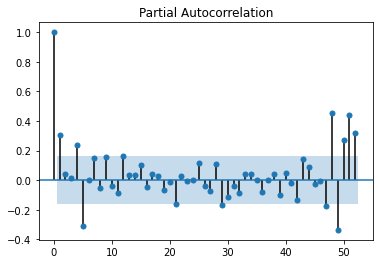

In [227]:
plot_pacf(Weekly_Sales['Weekly_Sales'], lags = 52);

#### 4. Interpreting the `ACF` and `PACF` Plots

**4a. What do the ACF and PACF graphs tell you about your sales data?**

**Answer:** According to the ACF plot towards the beginning of the year and the end of the year are the most statistically significant. In the PACF plot we can detect seasonality because towards the end of the year we can see a lot of statistical signnificance in our points.

**4b. How do the `ACF` and `PACF` inform your model selections moving forward?**

**Answer:** With these plots we can see that using y-1 and y-2 will most likely not be the best idea since they are fairly correlated with each other. We will have to remeber the LINE assumption when moving forward.

## Modeling

**5. Train/Test Split**  

Modeling with time series data presents unique challenges because our observations are not independent of one another. 

So, in splitting the data into `training` and `test` sets, **we cannot split randomly**. Use the first *75%* of observations as training data and the following 25% for test data. You can do this using `train_test_split` with a specific parameter, or can manually define it how it is set up below.

In [228]:
y_train, y_test = train_test_split(Weekly_Sales['Weekly_Sales'],
                                   test_size = .25,
                                   shuffle = False)

#### 6. Autoregressive Model

We will start by building a simple autoregressive model first: the `AR(1)` model. (*Note that this is the same thing as an ARIMA(1,0,0) model.*)

**6a. Instantiate and fit an `AR(1)` model.**

In [231]:
model = ARIMA(endog=y_train.astype(float).dropna(), order = (1, 0, 0))

In [232]:
arima = model.fit()

**6b. Calculate the Mean Squared Error of the `AR(1)` on your training set and your test set.**


In [233]:
model.score(y_train)

Exception: Data must be 1-dimensional

**6c. How effective do you think this `AR(1)` model is?**

Answer:

#### 7. Residual Plot  
Mean squared error is a good way to evaluate our model's performance. However, this doesn't tell the whole story. Is our model off by a lot in one specific window of time? Is our model only slightly off, but over all time? It might be helpful to plot residuals to see when our model is off most.

**7a. Calculate and and plot the residuals of your `AR(1)` model. (*Remember that a residual is just the actual value minus the predicted value.*)**

From this plot we can see that there are clearly errors in our predictions. 

**7b. What do the residual plots reveal about our model?**

Answer:

#### 8. AR vs. ARMA Models 


**8a. Let's fit an `AR(2)` model. Calculate the MSE on the training and testing sets, then plot the residuals.**

**8b. How did your results change?**

Answer:

**8c. Fit an `ARMA(2,2)` model. Calculate the MSE on the training and testing sets, then plot the residuals.** (_Note that an `ARMA(2,2)` model is the same as an `ARIMA(2,0,2)` model._)

**8d. How do the errors and residuals change from `AR(2)` to `ARMA(2,2)`?**



Answer:

#### 9. Stationary Data

Remember that one assumption to using the ARIMA model is that our data are **stationary**. This is a necessary assumption for our model, and it is important for us to check for it whenever we fit a time series model.

**9a. Use the Augmented Dickey-Fuller test to estimate whether or not your data are stationary.**

**9b. Interpret the results of the Augmented Dickey-Fuller test.**

Answer:

#### 10. Differenced Data

Regardless of what you found above, now we're going to take a look at differenced data.

**10a. Create new columns in your `Weekly_Sales` dataframe.**
- One column should be `Weekly_Sales` differenced by 1 time period.
- Another column should be `Weekly_Sales` differenced by 2 time periods.
- Another column should be `Weekly_Sales` differenced by 3 time periods.
- Another column should be `Weekly_Sales` differenced by 4 time periods.

**10b. Conduct and interpret the Augmented Dickey-Fuller test on each differenced column to test for stationarity.**

**10c. For which (if any) of the columns does it seem meaningful to have differenced the data?**

Answer:

**10d. Based on these tests and the ACF/PACF plots above, do you think that using an Integrated AutoRegressive Moving Average (ARIMA) model makes sense? Why or why not?**

Answer:

#### 11.  ARIMA MODEL

Based on your interpretation of the results from your tests for stationarity, and information gleaned from your ACF and PACF plots, choose a value of `d` to use in the `ARIMA(2,d,2)`.

**11a. Fit an `ARIMA(2,d,2)` model for the value of `d` you have chosen. Using whichever metric(s) you think best suit this problem (don't forget to import them above!), evaluate your model on the training and testing sets and generate a residual plot.**

**11b. Interpret the results from the last answer.**


Answer:

#### 12.  BONUS [12a-12b]: SARIMAX Model
We have looked at autocorrelation of neighboring values (i.e. comparing $Y_t$ to $Y_{t-1}$ or $Y_t$ to $Y_{t-4}$). However, what about seasonal affects on our data? How might the sales today be related to sales 6 months ago or a year ago?

Let's build a SARIMAX model!

**12a. Using `PACF` and `ACF` plots with appropriate intervals (think months in a year) try to build the best SARIMAX model you can in setting the `seasonal_order = (P, D, Q, S)` and using `order = (2, 0, 2)`, fit and evaluate the model as we have done in the prior models**.

**12b. How did your best SARIMAX model perform?**

Answer:

### 13. Your Best Model

**13a. In the cells below, bring together your best model, including:**
- the model itself,  
- at least one metric evaluating the model,
- and at least 2 visuals: a plot of the data/predictions and a plot of the residuals.

**13b. How did you decide this was your best model? How does your model perform at predicting weekly sales moving forward? Please use the metrics/visuals you included above to support your answer.** 

Answer: 

**13c. How might you improve this model?**

Answer:

### 14. BONUS: Rolling Predictions

**Try testing the performance of your model using rolling predictions. For each testing observation $Y_t$ you should train your model using data up to $Y_{t-1}$. This allows us to make meaningful predictions for all testing observations** 

Answer: